For the creation of a groundwater market, we will be first be using the MODFLOW response matrix to define our initial and boundary conditions for the groundwater basin. MODFLOW, a open source groundwater modelling program developed by the USGS, is the most commonly used hydrogeologic model for determining a variety of parameters (including sustainable yield, most important for trading in an allocation based basin) and uses a finite difference model to solve a partial differential equation for drawdown s at well w at time period t for all S, W, and T defined in the model. 

A significant advancement in the creation of a groundwater market is the ability to automate MODFLOW input and post-processing using the Python library Flopy. I wish to demonstrate the ability of this Python library here, based upon an online tutorial. 


In [1]:
import numpy as np
import flopy

In [2]:
# Model domain and grid definition
Lx = 1000.
Ly = 1000.
ztop = 10.
zbot = -50.
nlay = 1
nrow = 10
ncol = 10
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)
hk = 1.
vka = 1.
sy = 0.1
ss = 1.e-4
laytyp = 1

In [3]:
# Variables for the BAS package
# Note that changes from the previous tutorial!
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32)

In [4]:
# Time step parameters
nper = 3
perlen = [1, 100, 100]
nstp = [1, 100, 100]
steady = [True, False, False]

In [5]:
# Flopy objects
modelname = 'tutorial2'
mf = flopy.modflow.Modflow(modelname, exe_name='mf2k_gwt')
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm[1:],
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)
pcg = flopy.modflow.ModflowPcg(mf)

In [6]:
# Make list for stress period 1
stageleft = 10.
stageright = 10.
bound_sp1 = []
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc
    condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft])
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])
print('Adding ', len(bound_sp1), 'GHBs for stress period 1.')

# Make list for stress period 2
stageleft = 10.
stageright = 0.
condleft = hk * (stageleft - zbot) * delc
condright = hk * (stageright - zbot) * delc
bound_sp2 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])
print('Adding ', len(bound_sp2), 'GHBs for stress period 2.')

# We do not need to add a dictionary entry for stress period 3.
# Flopy will automatically take the list from stress period 2 and apply it
# to the end of the simulation, if necessary
stress_period_data = {0: bound_sp1, 1: bound_sp2}

# Create the flopy ghb object
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)

Adding  20 GHBs for stress period 1.
Adding  20 GHBs for stress period 2.


In [7]:
# Create the well package
# Remember to use zero-based layer, row, column indices!
pumping_rate = -100.
wel_sp1 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]
wel_sp2 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]
wel_sp3 = [[0, nrow/2 - 1, ncol/2 - 1, pumping_rate]]
stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)

In [8]:
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ['save head',
                                            'save drawdown',
                                            'save budget',
                                            'print head',
                                            'print budget']
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data,
                             compact=True)

In [9]:
# Write the model input files
mf.write_input()

# Run the model
success, mfoutput = mf.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

Levels:  [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
Extent:  (50.0, 950.0, 50.0, 950.0)
*****Processing time:  1.0
Head statistics
  min:  10.0
  max:  10.0
  std:  0.0


C:\Users\aaron\Anaconda3\lib\site-packages\matplotlib\quiver.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\aaron\Anaconda3\lib\site-packages\matplotlib\quiver.py:664: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\aaron\Anaconda3\lib\site-packages\matplotlib\quiver.py:720: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
C:\Users\aaron\Anaconda3\lib\site-packages\matplotlib\quiver.py:734: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


*****Processing time:  101.0
Head statistics
  min:  0.0259311
  max:  9.99844
  std:  3.2575
*****Processing time:  201.0
Head statistics
  min:  0.01802
  max:  9.99454
  std:  3.18991


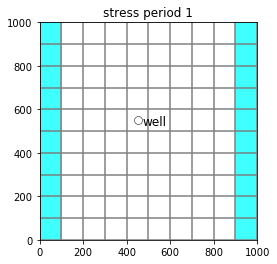

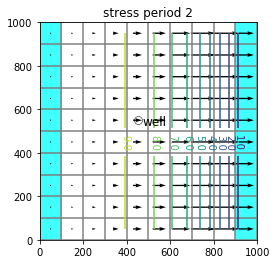

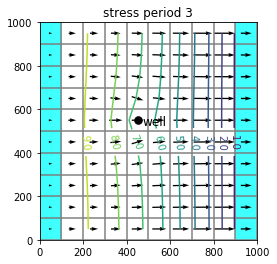

In [13]:
# Imports
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
%matplotlib inline

# Create the headfile and budget file objects
headobj = bf.HeadFile(modelname+'.hds')
times = headobj.get_times()
cbb = bf.CellBudgetFile(modelname+'.cbc')

# Setup contour parameters
levels = np.linspace(0, 10, 11)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
print('Levels: ', levels)
print('Extent: ', extent)

# Well point
wpt = ((float(ncol/2)-0.5)*delr, (float(nrow/2-1)+0.5)*delc)
wpt = (450., 550.)

# Make the plots
mytimes = [1.0, 101.0, 201.0]
for iplot, time in enumerate(mytimes):
    print('*****Processing time: ', time)
    head = headobj.get_data(totim=time)
    #Print statistics
    print('Head statistics')
    print('  min: ', head.min())
    print('  max: ', head.max())
    print('  std: ', head.std())

    # Extract flow right face and flow front face
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=time)[0]

    #Create the plot
    f = plt.figure()
    plt.subplot(1, 1, 1, aspect='equal')
    plt.title('stress period ' + str(iplot + 1))


    modelmap = flopy.plot.ModelMap(model=mf, layer=0)
    qm = modelmap.plot_ibound()
    lc = modelmap.plot_grid()
    qm = modelmap.plot_bc('GHB', alpha=0.5)
    cs = modelmap.contour_array(head, levels=levels)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%1.1f', zorder=11)
    quiver = modelmap.plot_discharge(frf, fff, head=head)


    mfc = 'None'
    if (iplot+1) == len(mytimes):
        mfc='black'
    plt.plot(wpt[0], wpt[1], lw=0, marker='o', markersize=8,
             markeredgewidth=0.5,
             markeredgecolor='black', markerfacecolor=mfc, zorder=9)
    plt.text(wpt[0]+25, wpt[1]-25, 'well', size=12, zorder=12)
    plt.savefig('tutorial2-{}.png'.format(iplot))

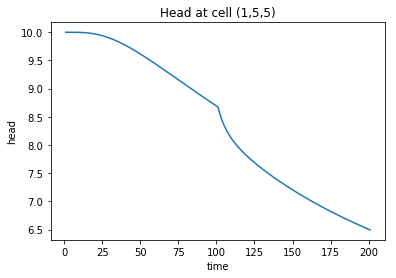

In [15]:
# Plot the head versus time
idx = (0, int(nrow/2) - 1, int(ncol/2) - 1)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time')
plt.ylabel('head')
plt.plot(ts[:, 0], ts[:, 1])
plt.savefig('tutorial2-ts.png')